# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 50
epochs = 100
lr = 3e-4
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
### read csv from Song-Mao


train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


#os.makedirs('../data', exist_ok=True)

In [8]:
test_df.tail()


train_dir = '/media/joshua/Milano/galaxy_zoo/train/'
test_dir = '/media/joshua/Milano/galaxy_zoo/test/'



In [9]:
train_df["GalaxyID"][0] == int(100008)

True

In [10]:
# with zipfile.ZipFile('../data/train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('../data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [11]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [12]:
 
print(f"Test Data: {len(test_list)}")

Train Data: 46183
Test Data: 15395


In [13]:
labels = train_df['label']


## Random Plots

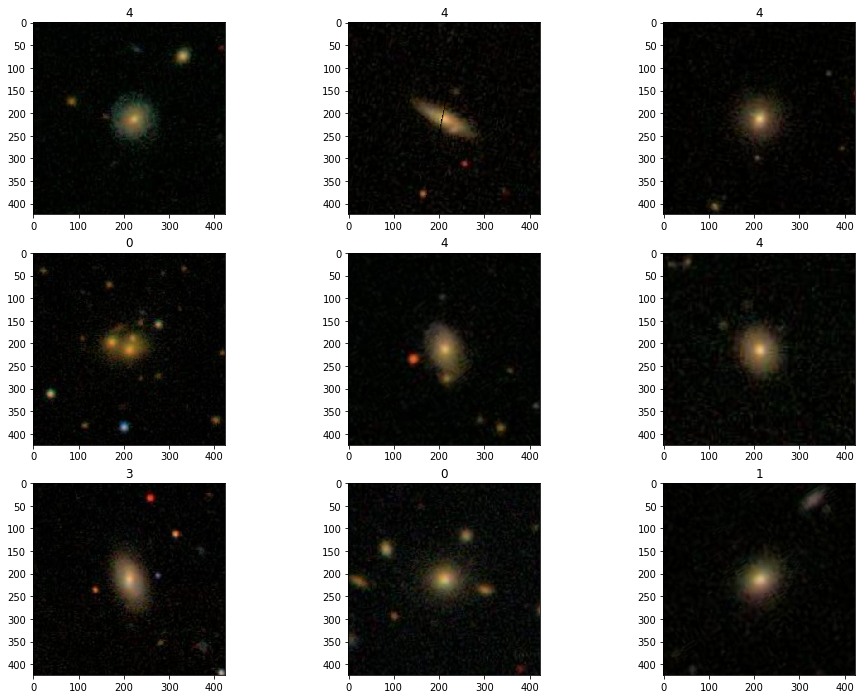

In [14]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [15]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)

In [16]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 36946
Validation Data: 9237
Test Data: 15395


## Image Augumentation

In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [18]:
class Galaxy_ZooDataset(Dataset):
    def __init__(self, file_list, transform=None, train=True, val=False, test=False):
        self.file_list = file_list
        self.transform = transform
        self.train = train
        self.val = val
        self.test = test
        self.train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
        self.test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        ID = img_path.split("/")[-1].split(".")[0]
        ID = int(ID)
        #print("ID", ID)

        
        
        #print("image_path", img_path)
        if self.train or self.val:
            label = train_df[train_df['GalaxyID']==ID].label 
            #print(train_df[train_df['GalaxyID']==ID])
            
        else:
            label = test_df[test_df['GalaxyID']==ID].label 
        #print(label.values[0])
        label = int(label.values[0])

        return img_transformed, label


In [19]:
train_data = Galaxy_ZooDataset(train_list, transform=train_transforms, train=True, val=False, test=False)
valid_data = Galaxy_ZooDataset(valid_list, transform=test_transforms, train=False, val=True, test=False)
test_data = Galaxy_ZooDataset(test_list, transform=test_transforms, train=False, val=False, test=True)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
print(len(train_data), len(train_loader))

36946 739


In [22]:
print(len(valid_data), len(valid_loader))

9237 185


## Effecient Attention

### Linformer

In [23]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [24]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [25]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [26]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            #print("label", label)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 1.0045 - acc: 0.5946 - val_loss : 0.9589 - val_acc: 0.6029




Epoch : 2 - loss : 0.9478 - acc: 0.6044 - val_loss : 0.9305 - val_acc: 0.6132




Epoch : 3 - loss : 0.9338 - acc: 0.6117 - val_loss : 0.9233 - val_acc: 0.6143




Epoch : 4 - loss : 0.9245 - acc: 0.6119 - val_loss : 0.9165 - val_acc: 0.6218




Epoch : 5 - loss : 0.9170 - acc: 0.6164 - val_loss : 0.9037 - val_acc: 0.6209




Epoch : 6 - loss : 0.9134 - acc: 0.6207 - val_loss : 0.9097 - val_acc: 0.6265




Epoch : 7 - loss : 0.9011 - acc: 0.6281 - val_loss : 0.8862 - val_acc: 0.6381




Epoch : 8 - loss : 0.8884 - acc: 0.6351 - val_loss : 0.8938 - val_acc: 0.6406




Epoch : 9 - loss : 0.8822 - acc: 0.6373 - val_loss : 0.8714 - val_acc: 0.6457




Epoch : 10 - loss : 0.8744 - acc: 0.6392 - val_loss : 0.8620 - val_acc: 0.6435




Epoch : 11 - loss : 0.8657 - acc: 0.6437 - val_loss : 0.8599 - val_acc: 0.6433




Epoch : 12 - loss : 0.8594 - acc: 0.6484 - val_loss : 0.8537 - val_acc: 0.6517




Epoch : 13 - loss : 0.8533 - acc: 0.6479 - val_loss : 0.8402 - val_acc: 0.6549




Epoch : 14 - loss : 0.8467 - acc: 0.6530 - val_loss : 0.8385 - val_acc: 0.6514




Epoch : 15 - loss : 0.8414 - acc: 0.6542 - val_loss : 0.8331 - val_acc: 0.6627




Epoch : 16 - loss : 0.8333 - acc: 0.6569 - val_loss : 0.8198 - val_acc: 0.6579




Epoch : 17 - loss : 0.8208 - acc: 0.6629 - val_loss : 0.8130 - val_acc: 0.6695




Epoch : 18 - loss : 0.8046 - acc: 0.6713 - val_loss : 0.7898 - val_acc: 0.6762




Epoch : 19 - loss : 0.7917 - acc: 0.6768 - val_loss : 0.7781 - val_acc: 0.6828




Epoch : 20 - loss : 0.7832 - acc: 0.6809 - val_loss : 0.7713 - val_acc: 0.6871




Epoch : 21 - loss : 0.7768 - acc: 0.6813 - val_loss : 0.7699 - val_acc: 0.6859




Epoch : 22 - loss : 0.7698 - acc: 0.6860 - val_loss : 0.7629 - val_acc: 0.6903




Epoch : 23 - loss : 0.7654 - acc: 0.6893 - val_loss : 0.7621 - val_acc: 0.6876




Epoch : 24 - loss : 0.7583 - acc: 0.6923 - val_loss : 0.7540 - val_acc: 0.6925




Epoch : 25 - loss : 0.7546 - acc: 0.6944 - val_loss : 0.7707 - val_acc: 0.6825




Epoch : 26 - loss : 0.7524 - acc: 0.6942 - val_loss : 0.7512 - val_acc: 0.6954




Epoch : 27 - loss : 0.7465 - acc: 0.6965 - val_loss : 0.7395 - val_acc: 0.6973




Epoch : 28 - loss : 0.7425 - acc: 0.6988 - val_loss : 0.7489 - val_acc: 0.6918




Epoch : 29 - loss : 0.7381 - acc: 0.6974 - val_loss : 0.7532 - val_acc: 0.6918




Epoch : 30 - loss : 0.7380 - acc: 0.7009 - val_loss : 0.7230 - val_acc: 0.7089




Epoch : 31 - loss : 0.7309 - acc: 0.7028 - val_loss : 0.7334 - val_acc: 0.7054




Epoch : 32 - loss : 0.7307 - acc: 0.7019 - val_loss : 0.7214 - val_acc: 0.7066




Epoch : 33 - loss : 0.7284 - acc: 0.7033 - val_loss : 0.7357 - val_acc: 0.7009




Epoch : 34 - loss : 0.7238 - acc: 0.7051 - val_loss : 0.7323 - val_acc: 0.7028




Epoch : 35 - loss : 0.7230 - acc: 0.7058 - val_loss : 0.7183 - val_acc: 0.7120




Epoch : 36 - loss : 0.7231 - acc: 0.7059 - val_loss : 0.7535 - val_acc: 0.6967




Epoch : 37 - loss : 0.7166 - acc: 0.7074 - val_loss : 0.7302 - val_acc: 0.7066




Epoch : 38 - loss : 0.7169 - acc: 0.7105 - val_loss : 0.7134 - val_acc: 0.7143




Epoch : 39 - loss : 0.7133 - acc: 0.7128 - val_loss : 0.7300 - val_acc: 0.7058




Epoch : 40 - loss : 0.7104 - acc: 0.7129 - val_loss : 0.7178 - val_acc: 0.7061




Epoch : 41 - loss : 0.7107 - acc: 0.7123 - val_loss : 0.7158 - val_acc: 0.7107




Epoch : 42 - loss : 0.7105 - acc: 0.7131 - val_loss : 0.7130 - val_acc: 0.7060




Epoch : 43 - loss : 0.7074 - acc: 0.7139 - val_loss : 0.7118 - val_acc: 0.7171




Epoch : 44 - loss : 0.7062 - acc: 0.7142 - val_loss : 0.7096 - val_acc: 0.7137




Epoch : 45 - loss : 0.7018 - acc: 0.7166 - val_loss : 0.7076 - val_acc: 0.7107




Epoch : 46 - loss : 0.7039 - acc: 0.7135 - val_loss : 0.7120 - val_acc: 0.7096




Epoch : 47 - loss : 0.6945 - acc: 0.7180 - val_loss : 0.7099 - val_acc: 0.7102




Epoch : 48 - loss : 0.6938 - acc: 0.7188 - val_loss : 0.6988 - val_acc: 0.7157




Epoch : 49 - loss : 0.6975 - acc: 0.7187 - val_loss : 0.7099 - val_acc: 0.7150




Epoch : 50 - loss : 0.6935 - acc: 0.7179 - val_loss : 0.6980 - val_acc: 0.7139




Epoch : 51 - loss : 0.6907 - acc: 0.7205 - val_loss : 0.7068 - val_acc: 0.7129




Epoch : 52 - loss : 0.6915 - acc: 0.7178 - val_loss : 0.6993 - val_acc: 0.7157




Epoch : 53 - loss : 0.6881 - acc: 0.7213 - val_loss : 0.7034 - val_acc: 0.7194




Epoch : 54 - loss : 0.6874 - acc: 0.7225 - val_loss : 0.6976 - val_acc: 0.7161




Epoch : 55 - loss : 0.6844 - acc: 0.7215 - val_loss : 0.7020 - val_acc: 0.7152




Epoch : 56 - loss : 0.6835 - acc: 0.7230 - val_loss : 0.6887 - val_acc: 0.7227




Epoch : 57 - loss : 0.6775 - acc: 0.7255 - val_loss : 0.7020 - val_acc: 0.7163




Epoch : 58 - loss : 0.6792 - acc: 0.7246 - val_loss : 0.6902 - val_acc: 0.7217




Epoch : 59 - loss : 0.6775 - acc: 0.7281 - val_loss : 0.7160 - val_acc: 0.7103




Epoch : 60 - loss : 0.6740 - acc: 0.7277 - val_loss : 0.6815 - val_acc: 0.7225




Epoch : 61 - loss : 0.6750 - acc: 0.7258 - val_loss : 0.6799 - val_acc: 0.7271




Epoch : 62 - loss : 0.6686 - acc: 0.7278 - val_loss : 0.6882 - val_acc: 0.7230




Epoch : 63 - loss : 0.6673 - acc: 0.7305 - val_loss : 0.6887 - val_acc: 0.7172




Epoch : 64 - loss : 0.6685 - acc: 0.7290 - val_loss : 0.6807 - val_acc: 0.7223




Epoch : 65 - loss : 0.6640 - acc: 0.7317 - val_loss : 0.6790 - val_acc: 0.7269




Epoch : 66 - loss : 0.6620 - acc: 0.7334 - val_loss : 0.6779 - val_acc: 0.7243




Epoch : 67 - loss : 0.6625 - acc: 0.7355 - val_loss : 0.6734 - val_acc: 0.7294




Epoch : 68 - loss : 0.6587 - acc: 0.7334 - val_loss : 0.6822 - val_acc: 0.7281




Epoch : 69 - loss : 0.6598 - acc: 0.7324 - val_loss : 0.6752 - val_acc: 0.7268




Epoch : 70 - loss : 0.6586 - acc: 0.7375 - val_loss : 0.6723 - val_acc: 0.7295




Epoch : 71 - loss : 0.6528 - acc: 0.7353 - val_loss : 0.6744 - val_acc: 0.7296




Epoch : 72 - loss : 0.6480 - acc: 0.7382 - val_loss : 0.6846 - val_acc: 0.7270




Epoch : 73 - loss : 0.6456 - acc: 0.7396 - val_loss : 0.6697 - val_acc: 0.7320




Epoch : 74 - loss : 0.6459 - acc: 0.7396 - val_loss : 0.6620 - val_acc: 0.7337




Epoch : 75 - loss : 0.6543 - acc: 0.7359 - val_loss : 0.6799 - val_acc: 0.7220




Epoch : 76 - loss : 0.6444 - acc: 0.7402 - val_loss : 0.6635 - val_acc: 0.7355




Epoch : 77 - loss : 0.6430 - acc: 0.7383 - val_loss : 0.6654 - val_acc: 0.7345




Epoch : 78 - loss : 0.6403 - acc: 0.7429 - val_loss : 0.6642 - val_acc: 0.7306




Epoch : 79 - loss : 0.6360 - acc: 0.7432 - val_loss : 0.6630 - val_acc: 0.7349




Epoch : 80 - loss : 0.6365 - acc: 0.7437 - val_loss : 0.6601 - val_acc: 0.7367




Epoch : 81 - loss : 0.6337 - acc: 0.7452 - val_loss : 0.6544 - val_acc: 0.7385




Epoch : 82 - loss : 0.6339 - acc: 0.7457 - val_loss : 0.6653 - val_acc: 0.7331




Epoch : 83 - loss : 0.6345 - acc: 0.7449 - val_loss : 0.6645 - val_acc: 0.7279




Epoch : 84 - loss : 0.6316 - acc: 0.7469 - val_loss : 0.6643 - val_acc: 0.7280




Epoch : 85 - loss : 0.6277 - acc: 0.7442 - val_loss : 0.6619 - val_acc: 0.7333




Epoch : 86 - loss : 0.6282 - acc: 0.7467 - val_loss : 0.6512 - val_acc: 0.7391




Epoch : 87 - loss : 0.6288 - acc: 0.7466 - val_loss : 0.6582 - val_acc: 0.7362




Epoch : 88 - loss : 0.6265 - acc: 0.7499 - val_loss : 0.6560 - val_acc: 0.7392




Epoch : 89 - loss : 0.6229 - acc: 0.7493 - val_loss : 0.6446 - val_acc: 0.7403




Epoch : 90 - loss : 0.6241 - acc: 0.7455 - val_loss : 0.6561 - val_acc: 0.7393




Epoch : 91 - loss : 0.6229 - acc: 0.7471 - val_loss : 0.6525 - val_acc: 0.7375




Epoch : 92 - loss : 0.6186 - acc: 0.7488 - val_loss : 0.6485 - val_acc: 0.7383




Epoch : 93 - loss : 0.6169 - acc: 0.7490 - val_loss : 0.6577 - val_acc: 0.7397




Epoch : 94 - loss : 0.6149 - acc: 0.7532 - val_loss : 0.6393 - val_acc: 0.7391




Epoch : 95 - loss : 0.6177 - acc: 0.7502 - val_loss : 0.6514 - val_acc: 0.7410




Epoch : 96 - loss : 0.6179 - acc: 0.7509 - val_loss : 0.6425 - val_acc: 0.7432




Epoch : 97 - loss : 0.6150 - acc: 0.7531 - val_loss : 0.6520 - val_acc: 0.7406




Epoch : 98 - loss : 0.6103 - acc: 0.7550 - val_loss : 0.6650 - val_acc: 0.7303




Epoch : 99 - loss : 0.6106 - acc: 0.7542 - val_loss : 0.6412 - val_acc: 0.7422




Epoch : 100 - loss : 0.6087 - acc: 0.7541 - val_loss : 0.6566 - val_acc: 0.7354



In [27]:
val_output = model(data)
val_output




tensor([[-2.4366e+00,  2.1513e+00, -9.9983e+00, -2.7260e+00,  2.7709e+00],
        [ 6.7426e-01, -1.9249e+00, -1.2151e+01, -2.7518e+00,  3.7533e+00],
        [-2.8531e+00,  2.9514e+00, -1.0940e+01, -3.3988e+00,  3.1890e+00],
        [-1.7367e+00,  9.7961e-01, -9.4335e+00, -3.0216e+00,  3.4929e+00],
        [ 2.1281e-01, -5.2109e-01, -8.9724e+00, -8.7396e-01,  1.4955e+00],
        [-1.6985e+00,  1.4877e+00, -1.0465e+01, -2.9522e+00,  2.9513e+00],
        [-5.4324e-01,  1.0659e+00, -9.1202e+00, -1.0787e+00,  1.1468e+00],
        [-3.1421e+00,  2.9533e+00, -1.0357e+01,  6.6841e-02,  1.3613e+00],
        [-4.6552e+00,  2.9696e+00, -1.0635e+01, -1.6485e+00,  3.0989e+00],
        [ 2.2073e+00, -4.8550e+00, -1.1304e+01, -2.3165e+00,  4.6103e+00],
        [-2.8865e-01, -3.3794e-01, -1.2520e+01, -2.4562e+00,  3.2898e+00],
        [-2.4545e+00,  2.0351e+00, -1.1276e+01, -3.5103e+00,  3.9386e+00],
        [-2.3526e+00,  2.0939e+00, -1.0600e+01,  1.7623e-01,  8.7134e-01],
        [-3.6442e+00,  2.

In [28]:
test_data[0][1]

1

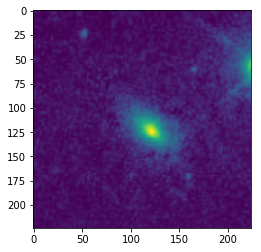

0
prediction tensor([4], device='cuda:0')


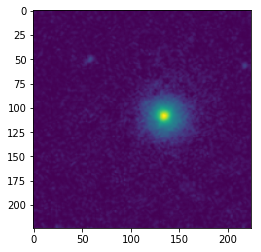

4
prediction tensor([4], device='cuda:0')


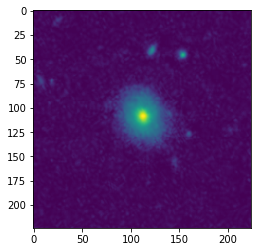

4
prediction tensor([4], device='cuda:0')


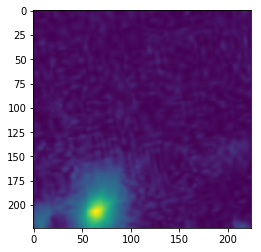

0
prediction tensor([4], device='cuda:0')


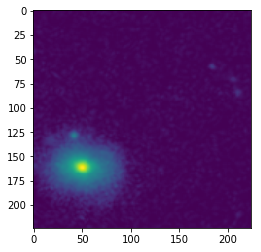

4
prediction tensor([4], device='cuda:0')


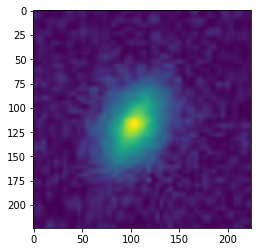

4
prediction tensor([4], device='cuda:0')


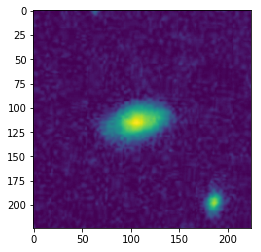

4
prediction tensor([4], device='cuda:0')


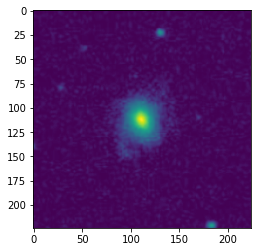

1
prediction tensor([1], device='cuda:0')


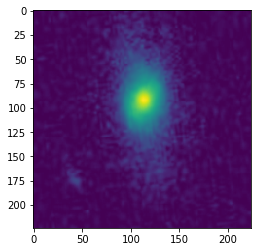

4
prediction tensor([4], device='cuda:0')


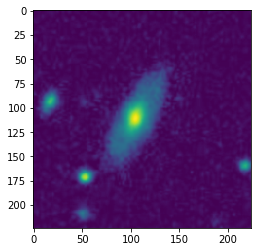

4
prediction tensor([1], device='cuda:0')


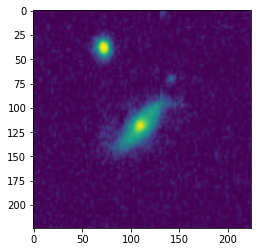

1
prediction tensor([4], device='cuda:0')


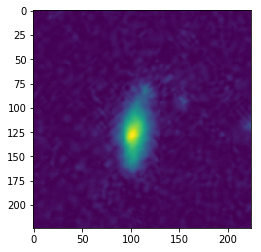

4
prediction tensor([1], device='cuda:0')


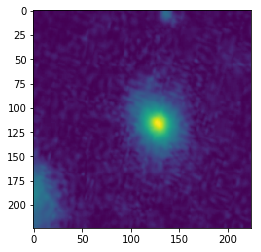

4
prediction tensor([4], device='cuda:0')


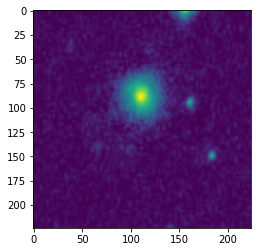

4
prediction tensor([4], device='cuda:0')


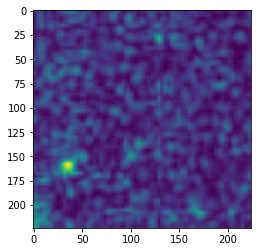

1
prediction tensor([4], device='cuda:0')


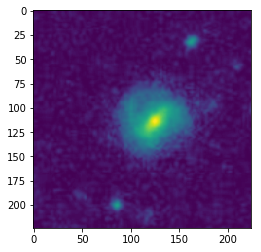

1
prediction tensor([4], device='cuda:0')


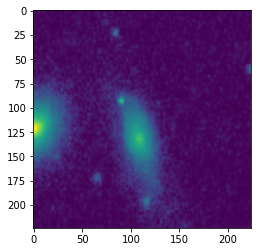

3
prediction tensor([0], device='cuda:0')


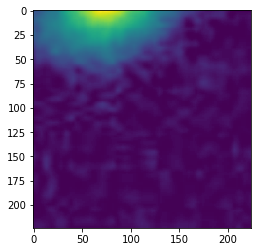

4
prediction tensor([4], device='cuda:0')


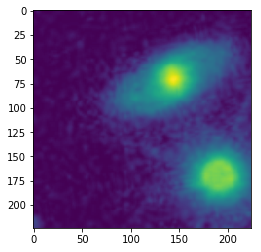

1
prediction tensor([1], device='cuda:0')


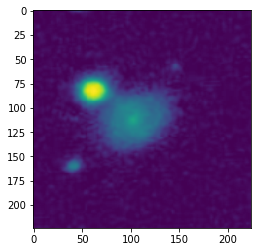

1
prediction tensor([1], device='cuda:0')


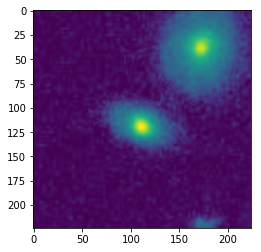

1
prediction tensor([3], device='cuda:0')


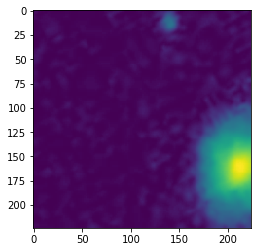

4
prediction tensor([4], device='cuda:0')


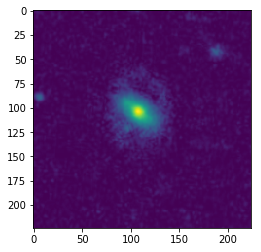

4
prediction tensor([4], device='cuda:0')


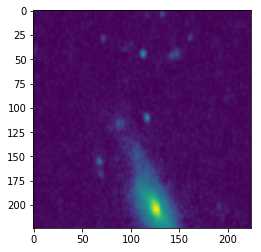

1
prediction tensor([4], device='cuda:0')


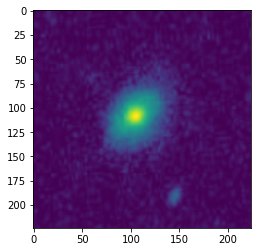

4
prediction tensor([4], device='cuda:0')


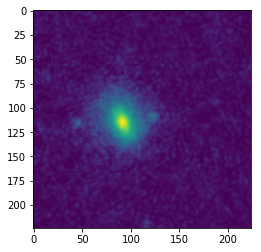

4
prediction tensor([4], device='cuda:0')


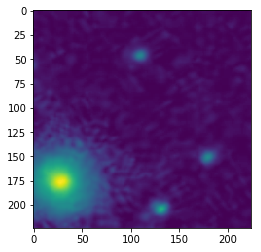

4
prediction tensor([4], device='cuda:0')


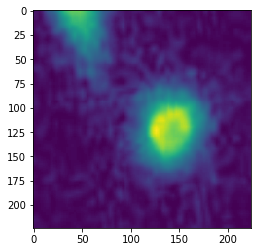

4
prediction tensor([4], device='cuda:0')


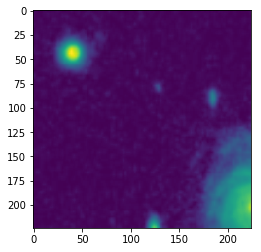

1
prediction tensor([1], device='cuda:0')


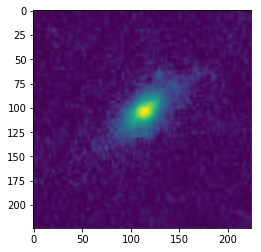

4
prediction tensor([1], device='cuda:0')


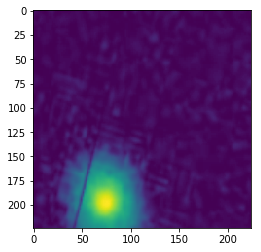

0
prediction tensor([4], device='cuda:0')


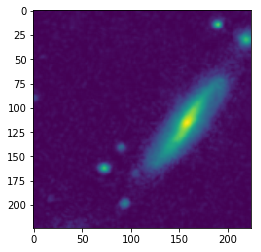

4
prediction tensor([4], device='cuda:0')


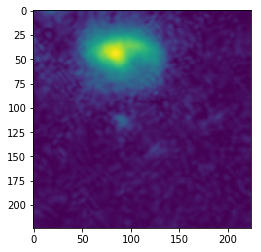

1
prediction tensor([1], device='cuda:0')


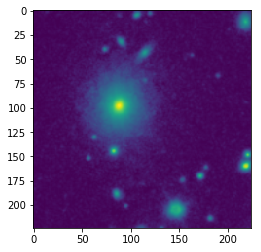

0
prediction tensor([4], device='cuda:0')


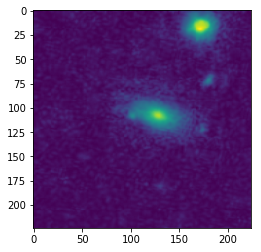

4
prediction tensor([4], device='cuda:0')


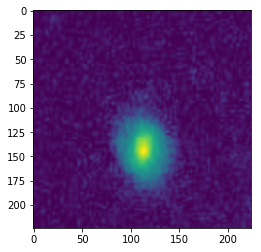

4
prediction tensor([4], device='cuda:0')


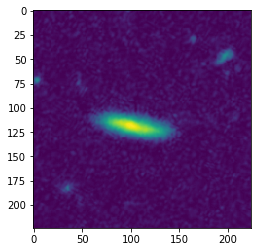

4
prediction tensor([4], device='cuda:0')


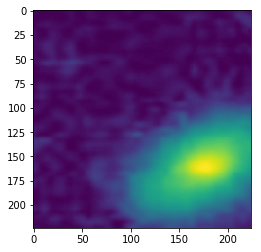

4
prediction tensor([4], device='cuda:0')


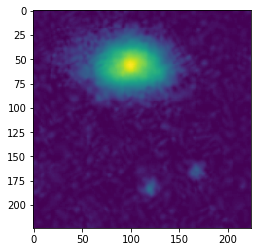

4
prediction tensor([4], device='cuda:0')


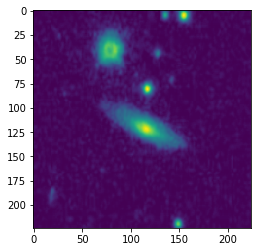

4
prediction tensor([4], device='cuda:0')


In [29]:
for idx in range(40):
    #img = Image.open(data[idx].cpu())
#     ax.set_title(labels[idx])
#     ax.imshow(test_data[idx])
    plt.imshow(valid_data[idx][0][0])
    #plt.title("label:", test_data[idx][1])
    plt.show()
    print(valid_data[idx][1])
    prediction_latent = model(valid_data[idx][0].unsqueeze(0).cuda())
    
    print("prediction", prediction_latent.argmax(dim=1))
    #print(valid_data[idx][0].shape)